In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Timing**

In [3]:
df_time_between_stops = pd.read_csv("2030 Time Between Stops By Line.csv")
display(df_time_between_stops)

# Create a dictionary mapping line numbers to travel times
line_to_time = dict(zip(df_time_between_stops["Line"], df_time_between_stops["Time Between Stops (mins)"]))

,Line,Time Between Stops (mins)
0,1.0,1.500
1,2.0,1.375
2,3.0,1.292
3,3.5,1.000
4,4.0,1.250
5,5.0,1.619
6,6.0,1.269
7,7.0,1.424
8,7.5,1.000
9,8.0,1.378


## **Priority Stations**

In [5]:
df_priority_stations = pd.read_csv("2030 Priority Stations.csv")
df_priority_stations["Priority Stations"] = df_priority_stations["Priority Stations"].str.replace(" ", "_")
priority_station_names = df_priority_stations["Priority Stations"].tolist()

display(df_priority_stations)

,Priority Stations,Built before 2021,2030 Predicted Traffic
0,ARCUEIL-CACHAN,N,2830821.0
1,AUBERVILLIERS-PANTIN-QUATRE_CHEMINS,Y,NaN
2,AULNAY_VAL_FRANCILIA,N,11182953.0
3,BAGNEUX,N,1439585.0
4,BARBARA,N,26563097.0
...,...,...,...
88,VILLEJUIF-GUSTAVE_ROUSSY,N,1043071.0
89,VILLEJUIF-LEO_LAGRANGE,Y,NaN
90,VILLEJUIF-LOUIS_ARAGON,Y,NaN
91,VILLEMOMBLE,N,11182953.0


## **Read in the graph and the data frame**

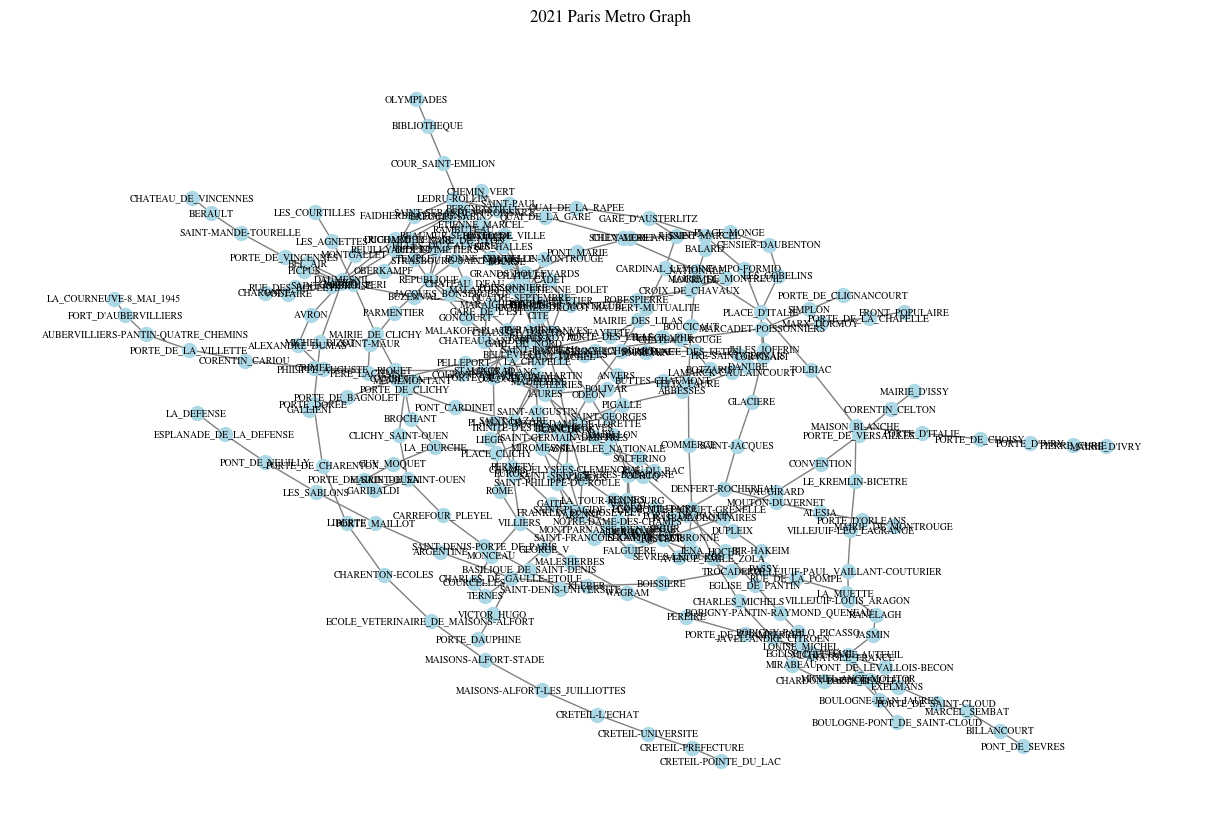

In [6]:
# Initialize an empty graph
G = nx.Graph()

# Read the graph file manually and parse edges
with open("graph_all_lines.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split(" ", 2)  # Split into first two parts + label dictionary
        if len(parts) == 3:
            node1, node2, attr_str = parts
            try:
                # Convert the attribute string into a dictionary
                attr_dict = eval(attr_str)  # Be cautious with eval() if the file is untrusted
                G.add_edge(node1, node2, **attr_dict)
            except SyntaxError:
                print(f"Skipping invalid line: {line.strip()}")

# Add traversal time as an edge attribute based on the line number
for u, v, data in G.edges(data=True):
    line = data.get("label")
    if line in line_to_time:
        G[u][v]["time"] = line_to_time[line]  # Assign travel time

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=7, font_family = 'STIXGeneral')
plt.title("2021 Paris Metro Graph")
plt.show()

In [7]:
df_2021 = pd.read_csv("all_2021_data.csv")
# Replace spaces with underscores in station names
df_2021["Station"] = df_2021["Station"].str.replace(" ", "_")

# Display the updated DataFrame
display(df_2021)

,ID,Network,Station,Traffic,First Line,Second Line,Third Line,Fourth Line,Fifth Line,Arrondissement for Paris,latitude,longitude
0,1,Metro,GARE_DU_NORD,34503097,4,5,NaN,NaN,NaN,10.0,48.880556,2.355000
1,2,Metro,SAINT-LAZARE,33128384,3,9,12,13.0,14.0,8.0,48.875490,2.326640
2,3,Metro,GARE_DE_LYON,28640475,1,14,A,NaN,NaN,12.0,48.844722,2.373889
3,4,Metro,MONTPARNASSE-BIENVENUE,20407224,4,6,12,13.0,NaN,14.0,48.843466,2.323072
4,5,Metro,GARE_DE_L'EST,15538471,4,5,7,NaN,NaN,10.0,48.876111,2.358333
...,...,...,...,...,...,...,...,...,...,...,...,...
299,301,Metro,BOLIVAR,367598,7bis,NaN,NaN,NaN,NaN,19.0,48.880502,2.374922
300,302,Metro,BUTTES-CHAUMONT,358301,7bis,NaN,NaN,NaN,NaN,19.0,48.878500,2.381772
301,303,Metro,PRE-SAINT-GERVAIS,282626,7bis,NaN,NaN,NaN,NaN,19.0,48.880250,2.398910
302,304,Metro,PELLEPORT,229524,3bis,NaN,NaN,NaN,NaN,20.0,48.868671,2.401752


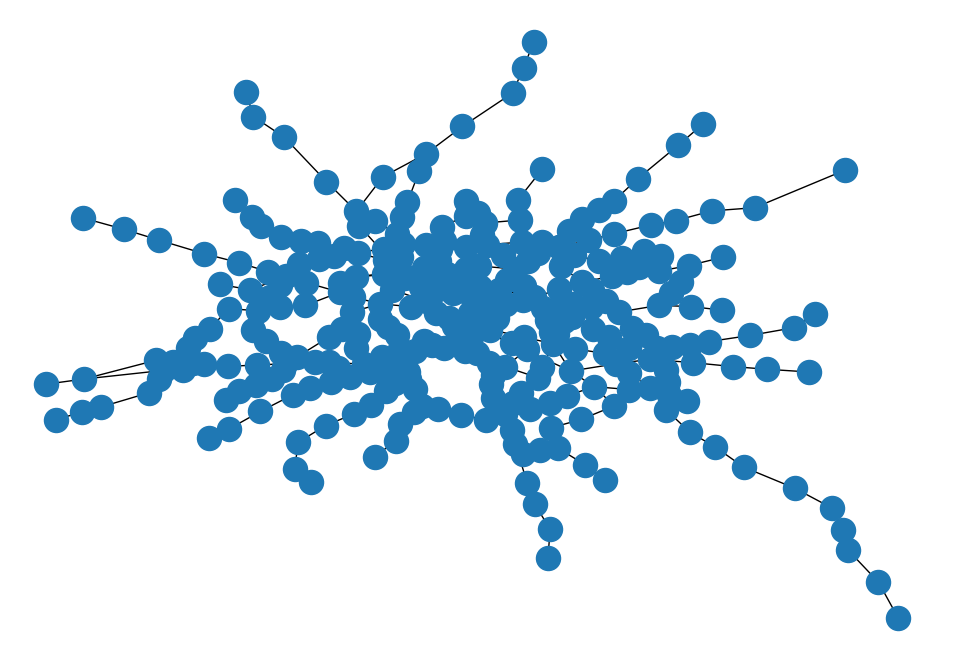

# of stations: 304


In [8]:
# Create a dictionary where keys are station names and values are (latitude, longitude) tuples
station_coordinates = {}
for index, row in df_2021.iterrows():
    station_coordinates[row['Station']] = (row['longitude'], row['latitude'])

plt.figure(figsize=(12, 8))  # Adjust the size as needed
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Extract longitude and latitude values from df1 to lists
longitude = df_2021['longitude'].tolist()
latitude = df_2021['latitude'].tolist()

plt.xlim([min(longitude) - 0.01, max(longitude) + 0.02])
plt.ylim([min(latitude) - 0.01 , max(latitude) + 0.01])
nx.draw(G, station_coordinates)
plt.show()  # Display the visualization

print("# of stations:", G.number_of_nodes())

## **The Simulation: Calculates the Two Traffic Metrics**

In [9]:
# Test out the inputs function for the G graph

def inputs():
    for station in G.nodes():
        random_probs = {}

        # Get shortest path lengths from the current station
        shortest_paths = nx.shortest_path_length(G, source=station)

        # Buckets for different travel distances
        long_trip = []  # 10+ stops
        medium_trip = []  # 5-10 stops
        short_trip = []  # <5 stops

        for node, distance in shortest_paths.items():
            if node == station:
                continue  # Skip self
            if distance >= 10:
                long_trip.append(node)
            elif 5 <= distance < 10:
                medium_trip.append(node)
            else:
                short_trip.append(node)

        # Assign probabilities based on the given distribution
        total_nodes = len(long_trip) + len(medium_trip) + len(short_trip)

        if total_nodes > 0:
            p_long = 0.3 / max(1, len(long_trip))
            p_medium = 0.35 / max(1, len(medium_trip))
            p_short = 0.35 / max(1, len(short_trip))

            for node in long_trip:
                random_probs[node] = p_long
            for node in medium_trip:
                random_probs[node] = p_medium
            for node in short_trip:
                random_probs[node] = p_short

        # Normalize the probabilities to sum to 1
        total_prob = sum(random_probs.values())
        if total_prob > 0:
            random_probs = {k: v / total_prob for k, v in random_probs.items()}

        # Assign a random lambda value (to be overwritten later)
        lambda_value = np.random.uniform(2, 10)

        # Store in graph
        G.nodes[station]["data"] = (random_probs, lambda_value)

    return G

G = inputs()

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

# Print the probability distribution for each node
for node in G.nodes():
    probs, lambda_val = G.nodes[node]['data']  # Unpack the tuple
    sorted_probs = dict(sorted(probs.items()))  # Sort the probabilities dictionary by key (destination node)
    print(f"Node {node}: ({sorted_probs}, {lambda_val})")

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# This is the complete version of the actual simulation

def update_node_with_lambda(G, lambda_dictionary):
  for node in G.nodes():
    G.nodes[node]["lambda"] = lambda_dictionary[node] / 100
  return G

def inputs(lambda_dictionary):
    for station in G.nodes():
        probs = {}

        # Get shortest path lengths from the current station
        shortest_paths = nx.shortest_path_length(G, source=station)

        # Buckets for different travel distances
        long_trip = []  # 10+ stops
        medium_trip = []  # 5-10 stops
        short_trip = []  # <5 stops

        for node, distance in shortest_paths.items():
            if node == station:
                continue  # Skip self
            if distance >= 10:
                long_trip.append(node)
            elif 5 <= distance < 10:
                medium_trip.append(node)
            else:
                short_trip.append(node)

        # Assign probabilities based on the given distribution
        total_nodes = len(long_trip) + len(medium_trip) + len(short_trip)

        if total_nodes > 0:
            p_long = 0.3 / max(1, len(long_trip))
            p_medium = 0.35 / max(1, len(medium_trip))
            p_short = 0.35 / max(1, len(short_trip))

            for node in long_trip:
                probs[node] = p_long
            for node in medium_trip:
                probs[node] = p_medium
            for node in short_trip:
                probs[node] = p_short

        # Normalize the probabilities to sum to 1
        total_prob = sum(probs.values())
        if total_prob > 0:
            probs = {k: v / total_prob for k, v in probs.items()}

        lambda_value = (lambda_dictionary[station] / 100)

        # Store in graph
        G.nodes[station]["data"] = (probs, lambda_value)

    return G

def simulate_arrivals(G, days):
    """Generates passenger arrivals at each station using a Poisson distribution."""
    arrivals = {}
    for station in G.nodes():
        _, lambda_value = G.nodes[station]["data"]
        arrivals[station] = np.random.poisson(lam=lambda_value, size=days)
    return arrivals

def simulate_passenger_journeys(G, daily_arrivals):
    journeys = []

    for station, arrivals in daily_arrivals.items():
        total_passengers = sum(arrivals)  # Total passengers arriving in the day

        for _ in range(total_passengers):
          # Get the probability distribution for the current station
          probs, _ = G.nodes[station]["data"]

          # Choose a destination based on the probability distribution
          if probs:  # Check if probs is not empty
              destinations = list(probs.keys())
              probabilities = list(probs.values())
              destination = np.random.choice(destinations, p=probabilities)
          else:
              # If probs is empty, choose a random destination (as a fallback)
              destination = np.random.choice([s for s in stations if s != station])

          path_nodes = nx.shortest_path(G, source=station, target=destination)
          path_edges = [(path_nodes[i], path_nodes[i + 1]) for i in range(len(path_nodes) - 1)]
          path_line_number = nx.get_edge_attributes(G, "label")
          path_length = nx.get_edge_attributes(G, "length")
          journeys.append(path_nodes)

    return journeys

def calculate_avg_transfers(G, results):
    """Calculates the average number of transfers that someone who starts at each station would have to make to get to their final destination."""

    station_transfers = {}  # Store total transfers for each starting station
    station_counts = {}    # Store the number of journeys starting from each station

    for person_id, journey in enumerate(results):
        start_station = journey[0]  # Get the starting station for this journey

        # If this is the first journey from this station, initialize counts
        station_transfers.setdefault(start_station, 0)
        station_counts.setdefault(start_station, 0)

        # Count the transfers for this journey (same logic as before)
        transfers = 0
        if len(journey) > 2:
            for i in range(len(journey) - 2):
                current_edge = (journey[i], journey[i + 1])
                next_edge = (journey[i + 1], journey[i + 2])
                if G.get_edge_data(*current_edge).get("label") != G.get_edge_data(*next_edge).get("label"):
                    transfers += 1

        station_transfers[start_station] += transfers  # Add transfers for this journey
        station_counts[start_station] += 1           # Increment journey count for this station

    # Calculate averages
    avg_transfers = {}
    for station in station_transfers:
        avg_transfers[station] = station_transfers[station] / station_counts[station]

    return avg_transfers

def calculate_path_time(G, path):
  """Calculates the total travel time for a given path,
  including a 4.50-minute penalty for each transfer."""

  total_time = 0
  transfers = 0  # Initialize transfer count

  for i in range(len(path) - 1):
    u, v = path[i], path[i + 1]
    try:
      time = G[u][v]["time"]
      total_time += time

      # Check for transfers (if not the first edge)
      if i > 0:
        current_line = G[path[i - 1]][path[i]].get("label")  # Get the line of the previous edge
        next_line = G[u][v].get("label")  # Get the line of the current edge

        if current_line != next_line:  # If lines are different, it's a transfer
          transfers += 1

    except KeyError:
      print(f"Warning: No time attribute found for edge ({u}, {v}). Skipping...")

  # Add transfer penalty to total time
  total_time += transfers * 4.50
  return total_time

def get_destination(path):
  return path[-1]  # The destination is the last element in the path

lambda_dictionary = dict(zip(df_2021['Station'], df_2021['Traffic'] / 365))
G = inputs(lambda_dictionary)
stations = list(G.nodes())
daily_arrivals = simulate_arrivals(G, 3)
G = update_node_with_lambda(G, lambda_dictionary)
results = simulate_passenger_journeys(G, daily_arrivals) # Run the simulation

# Create a list to store the data for the DataFrame
data_results = []
for i, journey in enumerate(results):
    data_results.append({'person_id': i + 1, 'path': journey})  # Store the entire path

# Create a DataFrame from the data
df_results = pd.DataFrame(data_results)
df_results['path_time'] = df_results['path'].apply(lambda path: calculate_path_time(G, path))

df_results['origin'] = df_results['path'].apply(lambda x: x[0])
df_results['destination'] = df_results['path'].apply(get_destination)

# Print the DataFrame
display(df_results)

average_path_time = df_results['path_time'].mean()
print(f"Average Path Time (mins): {average_path_time}")

# Calculate and print the average transfers
avg_transfers_result = calculate_avg_transfers(G, results)
print("The average # transfers a person who starts at each station needs to make to get to their destination")
print(avg_transfers_result)

,person_id,path,path_time,origin,destination
0,1,"[GAMBETTA, PERE_LACHAISE, PHILIPPE_AUGUSTE, AL...",32.816,GAMBETTA,ECOLE_VETERINAIRE_DE_MAISONS-ALFORT
1,2,"[GAMBETTA, PERE_LACHAISE, SAINT-MAUR, PARMENTI...",50.066,GAMBETTA,BASILIQUE_DE_SAINT-DENIS
2,3,"[GAMBETTA, PERE_LACHAISE, PHILIPPE_AUGUSTE, AL...",31.111,GAMBETTA,QUAI_DE_LA_GARE
3,4,"[GAMBETTA, PERE_LACHAISE, SAINT-MAUR, PARMENTI...",21.525,GAMBETTA,CHATEAU_ROUGE
4,5,"[GAMBETTA, PERE_LACHAISE, SAINT-MAUR, PARMENTI...",62.158,GAMBETTA,BOULOGNE-JEAN_JAURES
...,...,...,...,...,...
78069,78070,"[LA_DEFENSE, ESPLANADE_DE_LA_DEFENSE, PONT_DE_...",12.000,LA_DEFENSE,FRANKLIN_D._ROOSEVELT
78070,78071,"[LA_DEFENSE, ESPLANADE_DE_LA_DEFENSE]",1.500,LA_DEFENSE,ESPLANADE_DE_LA_DEFENSE
78071,78072,"[LA_DEFENSE, ESPLANADE_DE_LA_DEFENSE, PONT_DE_...",3.000,LA_DEFENSE,PONT_DE_NEUILLY
78072,78073,"[LA_DEFENSE, ESPLANADE_DE_LA_DEFENSE, PONT_DE_...",43.976,LA_DEFENSE,OURCQ


Average Path Time (mins): 19.986285011655607
The average # transfers a person who starts at each station needs to make to get to their destination
{'GAMBETTA': 2.131782945736434, 'PELLEPORT': 2.7058823529411766, 'PORTE_DE_BAGNOLET': 2.319502074688797, 'PERE_LACHAISE': 1.920863309352518, 'SAINT-FARGEAU': 2.945945945945946, 'PORTE_DES_LILAS': 2.1746575342465753, 'JAURES': 1.9912023460410557, 'STALINGRAD': 1.9645390070921986, 'LAUMIERE': 2.202572347266881, 'BOLIVAR': 2.7333333333333334, 'COLONEL_FABIEN': 2.3552123552123554, 'LOUIS_BLANC': 2.065040650406504, 'BOTZARIS': 2.05, 'BUTTES-CHAUMONT': 3.5, 'DANUBE': 1.9130434782608696, 'PLACE_DES_FETES': 1.6666666666666667, 'PRE-SAINT-GERVAIS': 2.1724137931034484, 'REPUBLIQUE': 1.6482300884955752, 'TEMPLE': 2.28, 'PARMENTIER': 2.6774193548387095, 'OBERKAMPF': 1.9186046511627908, 'STRASBOURG-SAINT-DENIS': 1.6989473684210525, 'GONCOURT': 2.2388059701492535, 'FILLES_DU_CALVAIRE': 2.466666666666667, 'JACQUES_BONSERGENT': 2.179310344827586, 'ARTS_ET_M

In [12]:
for node in G.nodes():
    _, lambda_val = G.nodes[node]['data']  # Unpack the tuple
    print(f"Node {node}: Lambda = {lambda_val}")

Node GAMBETTA: Lambda = 131.41709589041096
Node PELLEPORT: Lambda = 6.288328767123288
Node PORTE_DE_BAGNOLET: Lambda = 84.54219178082192
Node PERE_LACHAISE: Lambda = 94.93991780821918
Node SAINT-FARGEAU: Lambda = 12.938575342465754
Node PORTE_DES_LILAS: Lambda = 85.06893150684931
Node JAURES: Lambda = 111.1085205479452
Node STALINGRAD: Lambda = 134.9200821917808
Node LAUMIERE: Lambda = 89.27583561643836
Node BOLIVAR: Lambda = 10.07117808219178
Node COLONEL_FABIEN: Lambda = 83.38646575342466
Node LOUIS_BLANC: Lambda = 42.41175342465753
Node BOTZARIS: Lambda = 18.337616438356164
Node BUTTES-CHAUMONT: Lambda = 9.816465753424659
Node DANUBE: Lambda = 10.963205479452055
Node PLACE_DES_FETES: Lambda = 63.5277808219178
Node PRE-SAINT-GERVAIS: Lambda = 7.743178082191781
Node REPUBLIQUE: Lambda = 303.5536438356164
Node TEMPLE: Lambda = 24.434465753424657
Node PARMENTIER: Lambda = 55.814630136986295
Node OBERKAMPF: Lambda = 87.81123287671232
Node STRASBOURG-SAINT-DENIS: Lambda = 173.856712328767

In [13]:
def find_changing_stations(G, results):
    changing_stations_per_person = {}  # Dictionary to store changing stations for each person

    for person_id, journey in enumerate(results):
        changing_stations = []

        if len(journey) > 2:  # Only check for changes if the journey involves more than 2 stations
          for i in range(len(journey) - 2):
              current_edge = (journey[i], journey[i + 1])
              next_edge = (journey[i + 1], journey[i + 2])

              current_line = G.get_edge_data(*current_edge).get("label")  # Get the line of the current edge
              next_line = G.get_edge_data(*next_edge).get("label")  # Get the line of the next edge

              if current_line != next_line:  # If lines are different, it's a changing station
                  changing_stations.append(journey[i + 1])

        changing_stations_per_person[person_id + 1] = changing_stations  # Store for this person

    return changing_stations_per_person

def calculate_transfers_per_station(changing_stations_result):
    transfer_counts = {}  # Initialize an empty dictionary to store transfer counts for each station

    for person_transfers in changing_stations_result.values():  # Iterate through transfer stations for each person
        for station in person_transfers:  # Iterate through transfer stations for this person
            transfer_counts[station] = transfer_counts.get(station, 0) + 1  # Increment transfer count for this station

    return transfer_counts

changing_stations_result = find_changing_stations(G, results)
print(changing_stations_result)
transfer_counts_result = calculate_transfers_per_station(changing_stations_result)

# Print and download the data from transfer_counts_result
print("Number of transfers that happen at each station:", transfer_counts_result)
transfer_counts_result_df = pd.DataFrame(list(transfer_counts_result.items()), columns=['Station', 'Transfer_Count'])
transfer_counts_result_df = transfer_counts_result_df.sort_values(by=['Transfer_Count'], ascending=False) # Sort by transfer count in descending order
transfer_counts_result_df.to_csv("transfer_counts_result.csv", index=False)

# Add the 'transfer_stations' column to the DataFrame
df_results['transfer_stations'] = df_results['person_id'].apply(lambda person_id: changing_stations_result.get(person_id, []))

# Display the updated DataFrame
display(df_results)

df_results.to_csv("df_results.csv", index=False)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Create the 'Station' column
stations = list(G.nodes())
df_congestion = pd.DataFrame({'Station': stations})

# Incoming Traffic
incoming_traffic = df_results['origin'].value_counts().rename_axis('Station').reset_index(name='Incoming Traffic')
df_congestion = pd.merge(df_congestion, incoming_traffic, on='Station', how='left')
df_congestion['Incoming Traffic'] = df_congestion['Incoming Traffic'].fillna(0).astype(int)

# Transfer Traffic
transfer_counts_series = pd.Series(transfer_counts_result, name='Transfer Traffic')
df_congestion = pd.merge(df_congestion, transfer_counts_series, left_on='Station', right_index=True, how='left')
df_congestion['Transfer Traffic'] = df_congestion['Transfer Traffic'].fillna(0).astype(int)

# Exiting Traffic
exiting_traffic = df_results['destination'].value_counts().rename_axis('Station').reset_index(name='Exiting Traffic')
df_congestion = pd.merge(df_congestion, exiting_traffic, on='Station', how='left')
df_congestion['Exiting Traffic'] = df_congestion['Exiting Traffic'].fillna(0).astype(int)

# Total Traffic
df_congestion['Total Traffic'] = df_congestion['Incoming Traffic'] + df_congestion['Transfer Traffic'] + df_congestion['Exiting Traffic']

# Save and display
display(df_congestion)
df_congestion.to_csv('df_congestion.csv', index=False)

,Station,Incoming Traffic,Transfer Traffic,Exiting Traffic,Total Traffic
0,GAMBETTA,387,988,277,1652
1,PELLEPORT,17,0,231,248
2,PORTE_DE_BAGNOLET,241,0,221,462
3,PERE_LACHAISE,278,1243,239,1760
4,SAINT-FARGEAU,37,0,201,238
...,...,...,...,...,...
299,GEORGE_V,285,0,293,578
300,LES_SABLONS,342,0,262,604
301,PONT_DE_NEUILLY,393,0,231,624
302,ESPLANADE_DE_LA_DEFENSE,365,0,274,639


The quartiles are as follows: 932.50 1877.00 3143.00


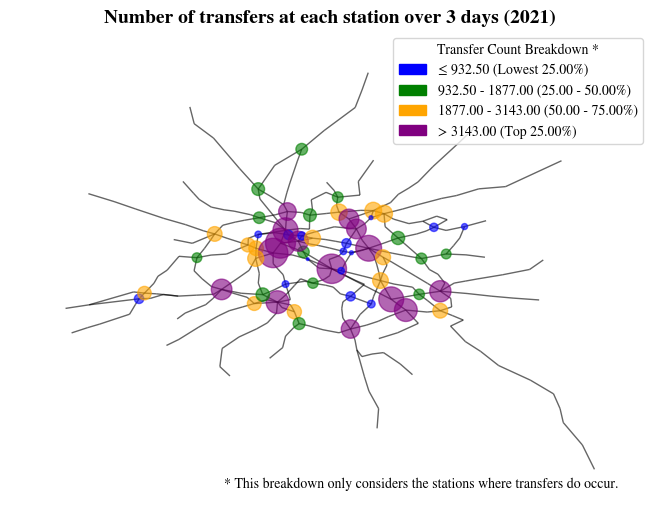

In [15]:
# The result shows the number of people transferring at each station

# Get transfer counts result values
transfer_counts_result_values = list(transfer_counts_result.values())

# Compute quartiles
q1, q2, q3 = np.percentile(transfer_counts_result_values, [25, 50, 75])

# Function to assign colors based on quartiles
def assign_color(value):
    if value <= q1:
        return "blue"
    elif value <= q2:
        return "green"
    elif value <= q3:
        return "orange"
    else:
        return "purple"

# Assign colors to each node
node_colors = [assign_color(transfer_counts_result.get(station, 0)) for station in G.nodes()]

# Get node sizes based on transfer_counts_result
node_sizes = [transfer_counts_result.get(station, 0) * 0.05 for station in G.nodes()]  # Scale size for better visualization

# Get node positions from station_coordinates
pos = {station: station_coordinates[station] for station in G.nodes()}

# Draw the graph with node sizes and positions
nx.draw(G, pos=pos, with_labels=False, node_size=node_sizes, node_color = node_colors, alpha = 0.6, font_family = 'STIXGeneral')

# Create a legend
legend_patches = [
    mpatches.Patch(color="blue", label=f"≤ {q1:.2f} (Lowest 25.00%)"),
    mpatches.Patch(color="green", label=f"{q1:.2f} - {q2:.2f} (25.00 - 50.00%)"),
    mpatches.Patch(color="orange", label=f"{q2:.2f} - {q3:.2f} (50.00 - 75.00%)"),
    mpatches.Patch(color="purple", label=f"> {q3:.2f} (Top 25.00%)"),
]

plt.legend(handles=legend_patches, title="Transfer Count Breakdown *", loc="upper right")

# Add a title
plt.title("Number of transfers at each station over 3 days (2021)", fontsize=14, fontweight="bold")
plt.text(0.95, 0.05, "* This breakdown only considers the stations where transfers do occur.",
         transform=plt.gca().transAxes, ha='right', fontsize=10)

print("The quartiles are as follows:", f"{q1:.2f}", f"{q2:.2f}", f"{q3:.2f}")

plt.savefig("transfer_counts_result_graph.pdf", bbox_inches='tight')

[1652, 248, 462, 1760, 238, 871, 3643, 3671, 618, 312, 551, 598, 275, 276, 231, 1090, 263, 8135, 353, 485, 2859, 1684, 481, 363, 458, 667, 5512, 1873, 361, 352, 400, 426, 739, 9984, 447, 417, 2027, 404, 385, 1218, 9120, 1350, 9468, 420, 1719, 10126, 419, 1076, 645, 383, 7322, 453, 381, 2486, 360, 301, 2359, 380, 357, 447, 2878, 632, 2693, 9572, 3264, 2871, 444, 297, 799, 609, 3592, 420, 493, 317, 335, 459, 385, 581, 378, 464, 455, 419, 416, 1991, 387, 393, 3919, 480, 2272, 559, 342, 316, 3569, 7209, 775, 679, 493, 2731, 440, 472, 437, 463, 486, 359, 354, 4881, 447, 1346, 352, 3119, 395, 436, 993, 430, 441, 530, 428, 1823, 742, 477, 417, 513, 503, 537, 1628, 317, 351, 410, 339, 2466, 1975, 346, 383, 506, 553, 600, 563, 491, 534, 449, 399, 432, 300, 1349, 4338, 326, 389, 1677, 389, 390, 431, 538, 422, 5132, 375, 343, 397, 462, 380, 353, 506, 473, 6040, 407, 526, 2856, 359, 382, 635, 451, 402, 5572, 421, 440, 442, 330, 1394, 293, 379, 382, 406, 470, 345, 452, 353, 420, 362, 469, 347, 346,

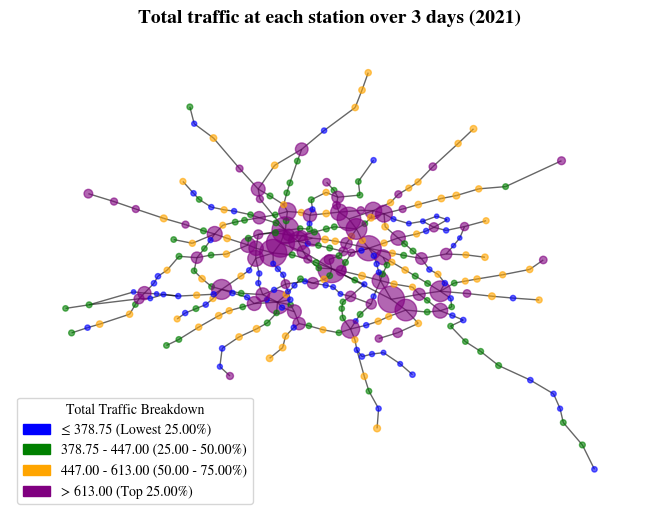

In [16]:
# Get Total Traffic values
total_traffic_values = df_congestion['Total Traffic'].tolist()
print(total_traffic_values)

# Compute quartiles
q1, q2, q3 = np.percentile(total_traffic_values, [25, 50, 75])

# Function to assign colors based on quartiles
def assign_color(value):
    if value <= q1:
        return "blue"
    elif value <= q2:
        return "green"
    elif value <= q3:
        return "orange"
    else:
        return "purple"

# Assign colors to each node
node_colors = [assign_color(traffic) for traffic in total_traffic_values]

# Get node sizes based on Total Traffic
node_sizes = [traffic * 0.04 for traffic in total_traffic_values]  # Scale size for better visualization

# Get node positions from station_coordinates
pos = {station: station_coordinates[station] for station in df_congestion['Station'].tolist()}

# Draw the graph with node sizes and positions
nx.draw(G, pos=pos, with_labels=False, node_size=node_sizes, node_color=node_colors, alpha=0.6, font_family='STIXGeneral')

# Create a legend
legend_patches = [
    mpatches.Patch(color="blue", label=f"≤ {q1:.2f} (Lowest 25.00%)"),
    mpatches.Patch(color="green", label=f"{q1:.2f} - {q2:.2f} (25.00 - 50.00%)"),
    mpatches.Patch(color="orange", label=f"{q2:.2f} - {q3:.2f} (50.00 - 75.00%)"),
    mpatches.Patch(color="purple", label=f"> {q3:.2f} (Top 25.00%)"),
]

plt.legend(handles=legend_patches, title="Total Traffic Breakdown", loc="lower left")

# Add a title
plt.title("Total traffic at each station over 3 days (2021)", fontsize=14, fontweight="bold")

print("The quartiles are as follows:", f"{q1:.2f}", f"{q2:.2f}", f"{q3:.2f}")

plt.savefig("total_2021_traffic_graph.pdf", bbox_inches='tight')

The quartiles are as follows: 1.71 1.97 2.23


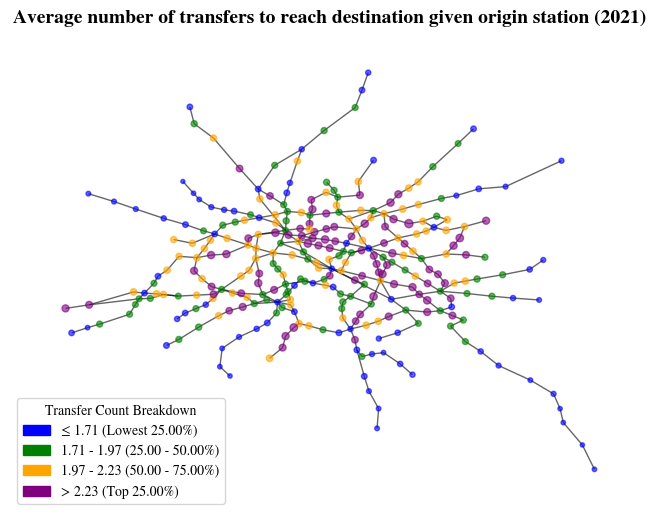

In [17]:
# The average number of transfers a person who starts at each station needs to make to get to their destination

# Get transfer counts result values
avg_transfers_result_values = list(avg_transfers_result.values())

# Compute quartiles
q1, q2, q3 = np.percentile(avg_transfers_result_values, [25, 50, 75])

# Function to assign colors based on quartiles
def assign_color(value):
    if value <= q1:
        return "blue"
    elif value <= q2:
        return "green"
    elif value <= q3:
        return "orange"
    else:
        return "purple"

# Assign colors to each node
node_colors = [assign_color(avg_transfers_result.get(station, 0)) for station in G.nodes()]

# Get node sizes based on transfer_counts_result
node_sizes = [avg_transfers_result.get(station, 0) * 10 for station in G.nodes()]  # Scale size for better visualization

# Get node positions from station_coordinates
pos = {station: station_coordinates[station] for station in G.nodes()}

# Draw the graph with node sizes and positions
nx.draw(G, pos=pos, with_labels=False, node_size=node_sizes, node_color = node_colors, alpha = 0.6, font_family = 'STIXGeneral')

# Create a legend
legend_patches = [
    mpatches.Patch(color="blue", label=f"≤ {q1:.2f} (Lowest 25.00%)"),
    mpatches.Patch(color="green", label=f"{q1:.2f} - {q2:.2f} (25.00 - 50.00%)"),
    mpatches.Patch(color="orange", label=f"{q2:.2f} - {q3:.2f} (50.00 - 75.00%)"),
    mpatches.Patch(color="purple", label=f"> {q3:.2f} (Top 25.00%)"),
]

plt.legend(handles=legend_patches, title="Transfer Count Breakdown", loc="lower left")

# Add a title
plt.title("Average number of transfers to reach destination given origin station (2021)", fontsize=14, fontweight="bold")

print("The quartiles are as follows:", f"{q1:.2f}", f"{q2:.2f}", f"{q3:.2f}")

plt.savefig("avg_transfers_result_graph.pdf", bbox_inches='tight')

## **Priority Stations Analysis**

In [18]:
display(df_priority_stations)
total_predicted_traffic = df_priority_stations["2030 Predicted Traffic"].sum()

# Print the total predicted traffic
print(f"Total 2030 Predicted Traffic: {total_predicted_traffic}")

# Define the percentages and travel times
percentage_long = 0.30
percentage_medium = 0.35
percentage_short = 0.35

# Times for people living near priority stations to get to their destination
# (notice the connection between the penalty for closures)
# (I subtracted from those times because people don't need to decide what to do/go back)
travel_time_long = 15  # minutes
travel_time_medium = 40  # minutes
travel_time_short = 70  # minutes

# Assume a total of 100 people for simplicity (you can adjust this)
total_people = total_predicted_traffic

# Calculate the number of people in each travel time category
people_long = total_people * percentage_long
people_medium = total_people * percentage_medium
people_short = total_people * percentage_short

# Calculate the total travel time for each category
total_time_long = people_long * travel_time_long
total_time_medium = people_medium * travel_time_medium
total_time_short = people_short * travel_time_short

# Calculate the overall total travel time
total_travel_time = total_time_long + total_time_medium + total_time_short

print(f"Total Travel Time for {total_people} people over the course of 1 year: {total_travel_time} minutes")
print(f"Total Travel Time for {total_people / 365} people over the course of 1 day: {total_travel_time / 365} minutes")
print(f"Total Travel Time for {total_people * 3 / 365} people over the course of 3 days: {total_travel_time * 3 / 365} minutes")

# Print the relevant value based on the parameters of the simulation
print(f"Total Travel Time for {total_people * 3 / 36500} people over the course of 3 days with reduced lambda: {total_travel_time * 3 / 36500} minutes")

,Priority Stations,Built before 2021,2030 Predicted Traffic
0,ARCUEIL-CACHAN,N,2830821.0
1,AUBERVILLIERS-PANTIN-QUATRE_CHEMINS,Y,NaN
2,AULNAY_VAL_FRANCILIA,N,11182953.0
3,BAGNEUX,N,1439585.0
4,BARBARA,N,26563097.0
...,...,...,...
88,VILLEJUIF-GUSTAVE_ROUSSY,N,1043071.0
89,VILLEJUIF-LEO_LAGRANGE,Y,NaN
90,VILLEJUIF-LOUIS_ARAGON,Y,NaN
91,VILLEMOMBLE,N,11182953.0


Total 2030 Predicted Traffic: 366744379.0
Total Travel Time for 366744379.0 people over the course of 1 year: 15770008297.0 minutes
Total Travel Time for 1004779.1205479453 people over the course of 1 day: 43205502.183561645 minutes
Total Travel Time for 3014337.3616438354 people over the course of 3 days: 129616506.55068493 minutes
Total Travel Time for 30143.373616438355 people over the course of 3 days with reduced lambda: 1296165.0655068492 minutes


In [19]:
# 1. Get the list of priority stations
priority_stations = df_priority_stations["Priority Stations"].tolist()

# 2. Filter df_results to include only priority stations
filtered_df = df_results[df_results["origin"].isin(priority_stations)]

# 3. Calculate the sum of all the path times for the filtered DataFrame
total_path_time_priority = filtered_df["path_time"].sum()

# 4. Calculate the average path_time for the filtered DataFrame
average_path_time_priority = filtered_df["path_time"].mean()

# 5. Calculate the number of people for the filtered DataFrame
num_people_priority = len(filtered_df)

print(f"Sum of the Path Times for Priority Stations: {total_path_time_priority}")
print(f"Average Path Time for Priority Stations: {average_path_time_priority}")
print(f"Number of People for Priority Stations: {num_people_priority}")

display(filtered_df)

Sum of the Path Times for Priority Stations: 281913.261
Average Path Time for Priority Stations: 20.4181401463026
Number of People for Priority Stations: 13807


,person_id,path,path_time,origin,destination,transfer_stations
0,1,"[GAMBETTA, PERE_LACHAISE, PHILIPPE_AUGUSTE, AL...",32.816,GAMBETTA,ECOLE_VETERINAIRE_DE_MAISONS-ALFORT,"[PERE_LACHAISE, NATION, REUILLY-DIDEROT]"
1,2,"[GAMBETTA, PERE_LACHAISE, SAINT-MAUR, PARMENTI...",50.066,GAMBETTA,BASILIQUE_DE_SAINT-DENIS,"[REPUBLIQUE, RICHELIEU-DROUOT, OPERA, SAINT-LA..."
2,3,"[GAMBETTA, PERE_LACHAISE, PHILIPPE_AUGUSTE, AL...",31.111,GAMBETTA,QUAI_DE_LA_GARE,"[PERE_LACHAISE, NATION, GARE_DE_LYON, BERCY]"
3,4,"[GAMBETTA, PERE_LACHAISE, SAINT-MAUR, PARMENTI...",21.525,GAMBETTA,CHATEAU_ROUGE,"[REPUBLIQUE, GARE_DU_NORD]"
4,5,"[GAMBETTA, PERE_LACHAISE, SAINT-MAUR, PARMENTI...",62.158,GAMBETTA,BOULOGNE-JEAN_JAURES,"[REPUBLIQUE, RICHELIEU-DROUOT, MADELEINE, CONC..."
...,...,...,...,...,...,...
74465,74466,"[BOBIGNY-PABLO_PICASSO, BOBIGNY-PANTIN-RAYMOND...",9.714,BOBIGNY-PABLO_PICASSO,LAUMIERE,[]
74466,74467,"[BOBIGNY-PABLO_PICASSO, BOBIGNY-PANTIN-RAYMOND...",25.458,BOBIGNY-PABLO_PICASSO,ALEXANDRE_DUMAS,[JAURES]
74467,74468,"[BOBIGNY-PABLO_PICASSO, BOBIGNY-PANTIN-RAYMOND...",17.208,BOBIGNY-PABLO_PICASSO,COLONEL_FABIEN,[JAURES]
74468,74469,"[BOBIGNY-PABLO_PICASSO, BOBIGNY-PANTIN-RAYMOND...",6.476,BOBIGNY-PABLO_PICASSO,PORTE_DE_PANTIN,[]


In [21]:
# Finally calculating the average time for a person starting at a priority station

final_2021_priority_avg_time = (total_path_time_priority + (total_travel_time * 3 / 36500)) / (num_people_priority + total_people * 3 / 36500)
print(f"The average time for a person starting at a priority station in 2021 is {final_2021_priority_avg_time} minutes. This metric considers people who live near 2021 and 2030 priority stations.")

The average time for a person starting at a priority station in 2021 is 35.905913799026614 minutes. This metric considers people who live near 2021 and 2030 priority stations.


The quartiles are as follows: 1.62 1.96 2.17


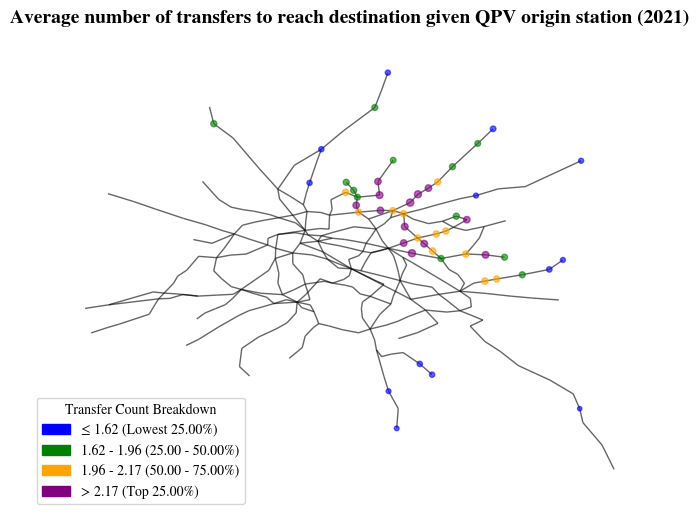

In [22]:
# For Priority Stations: The average number of transfers a person who starts at each station needs to make to get to their destination

priority_stations = df_priority_stations["Priority Stations"].tolist()

# Create a new dictionary with only the relevant stations
avg_transfers_result_priority = {
    station: avg_transfers_result[station]
    for station in priority_stations if station in avg_transfers_result
}

# Get transfer counts result values
avg_transfers_result_values_priority = list(avg_transfers_result_priority.values())

# Compute quartiles
q1, q2, q3 = np.percentile(avg_transfers_result_values_priority, [25, 50, 75])

# Function to assign colors based on quartiles
def assign_color(value):
    if value <= q1:
        return "blue"
    elif value <= q2:
        return "green"
    elif value <= q3:
        return "orange"
    else:
        return "purple"

# Assign colors to each node
node_colors = [assign_color(avg_transfers_result_priority.get(station, 0)) for station in G.nodes()]

# Get node sizes based on transfer_counts_result
node_sizes = [avg_transfers_result_priority.get(station, 0) * 10 for station in G.nodes()]  # Scale size for better visualization

# Get node positions from station_coordinates
pos = {station: station_coordinates[station] for station in G.nodes()}

# Draw the graph with node sizes and positions
nx.draw(G, pos=pos, with_labels=False, node_size=node_sizes, node_color = node_colors, alpha = 0.6, font_family = 'STIXGeneral')

# Create a legend
legend_patches = [
    mpatches.Patch(color="blue", label=f"≤ {q1:.2f} (Lowest 25.00%)"),
    mpatches.Patch(color="green", label=f"{q1:.2f} - {q2:.2f} (25.00 - 50.00%)"),
    mpatches.Patch(color="orange", label=f"{q2:.2f} - {q3:.2f} (50.00 - 75.00%)"),
    mpatches.Patch(color="purple", label=f"> {q3:.2f} (Top 25.00%)"),
]

plt.legend(handles=legend_patches, title="Transfer Count Breakdown", loc="lower left")

# Add a title
plt.title("Average number of transfers to reach destination given QPV origin station (2021)", fontsize=14, fontweight="bold")

print("The quartiles are as follows:", f"{q1:.2f}", f"{q2:.2f}", f"{q3:.2f}")

plt.savefig("avg_transfers_priority_result_graph.pdf", bbox_inches='tight')